In [2]:
import os
import sys
import cv2
import glob
from os.path import isfile, join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage
from IPython.display import display
from IPython.display import Image as _Imgdis
from IPython.display import Markdown

from ipywidgets import IntProgress

from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve
from sklearn import metrics

from sklearn.utils import shuffle
from sklearn.model_selection import KFold

import pandas as pd 

import json

# Tira os warning do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


# Objetivos

    O objetivo deste trabalho é criar uma CNN capaz de distinguir imagens de faces reais de faces que foram criadas por meio de Redes Generativas Adversárias.
    Também será verificado se o modelo criado é capaz de identificar imagens que foram criadas por uma GAN que não foi vista durante o treino do modelo.


# Resumo dos Dados

    Os dados utilizados para treino consistem em 32 mil imagens de faces reais e 32 mil imagens de faces criadas por 3 diferentes GANs: MMC-GAN, Faceswap-GAN e DiscoGAN sendo 10667 imagens de cada rede. Além disso foram utilizadas mais 10 mil imagens reais e outras 10 mil imagens geradas pela StarGAN para realizar um segundo teste no modelo proposto.
    
    As imagens reais foram retiradas do Flickr-Faces-HQ Dataset, conjunto de dados com 70 mil imagens de faces, e que pode ser acessado apartir do link: https://github.com/NVlabs/ffhq-dataset    
    Referência: KARRAS, Tero; LAINE, Samuli; AILA, Timo. A style-based generator architecture for generative adversarial networks. In: Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2019. p. 4401-4410.
    
    As imagens falsas provém de um projeto do KAIST MMC Lab chamado “fakeface-mmc” que têm cerca de 208 mil imagens e pode ser acessado através do link: http://fakeface.kaist.ac.kr/database
    Referência: TARIQ, Shahroz et al. Detecting both machine and human created fake face images in the wild. In: Proceedings of the 2nd International Workshop on Multimedia Privacy and Security. ACM, 2018. p. 81-87.
    
    As imagens que foram utilizadas podem ser acessadas apartir do link do Google Drive: https://drive.google.com/open?id=1M9o-VCXMCytEs6RxnkzKPwfQIzhwK38z

### Leitura das imagens Pré-Processadas

    Neste notebook faremos a leitura das imagens que já foram pré-processadas pelo método Pre-Processamento.ipynb, e nesse podem ser encontradas exemplos de imagens antes deste processo.
    Esse processo consiste em uma transformação para escala de cinza e redimensionamento. Foram testados outros tipos de pré-processamento como a inclusão de filtros de passa-baixa e passa-alta além da detecção das faces da imagem antes do treino porém esses não tiveram muita relevância para a otimização do modelo. 

In [2]:
# Imagens reais.
folderReal = "RealPPN"
onlyfilesReal = [f for f in os.listdir(folderReal) if os.path.isfile(os.path.join(folderReal, f))]
   
# Imagens fake. 
folderFake = "FakePPN"
onlyfilesFake = [f for f in os.listdir(folderFake) if os.path.isfile(os.path.join(folderFake, f))]

# Listas para as imagens e os labels.
n_img = len(onlyfilesReal) + len(onlyfilesFake)
images = np.empty((n_img,64,64), dtype=float)
images_labels = []

print("Carregando", n_img, "imagens...\n", "Progresso:")

# Barra de progresso.
progresso = IntProgress(min=0, max=n_img)
display(progresso)

# Leitura das imagens reais.
for n in range(0, len(onlyfilesReal)):
    images_labels.append(int(0))
    img = cv2.imread(join(folderReal,onlyfilesReal[n]),0)
    img = img/255
    images[n] = img
    progresso.value += 1
    
inicio2classe = n + 1  # Salva o inicio da proxima classe.

# Leitura das imagens fake.
for n in range(n, n_img-1):
    images_labels.append(int(1))
    img = cv2.imread(join(folderFake,onlyfilesFake[n-(inicio2classe-1)]),0)
    img = img/255
    images[n] = img
    progresso.value += 1
print("Concluído.")

images, images_labels = shuffle(images, images_labels)

Carregando 64000 imagens...
 Progresso:


IntProgress(value=0, max=64000)

Concluído.


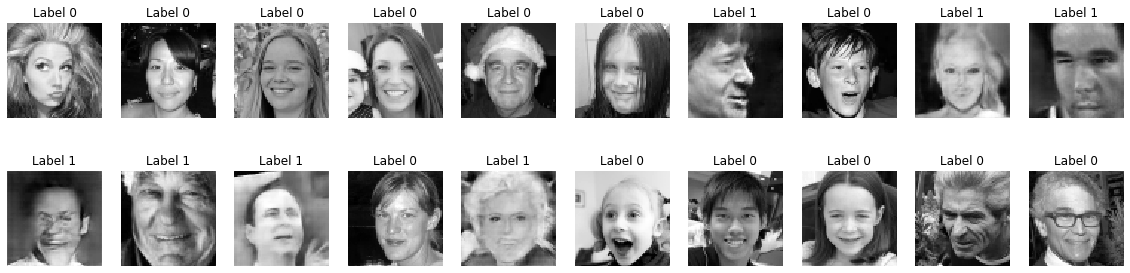

In [3]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, images.shape[0])
        axes[i][j].imshow(images[img_i], cmap="gray")
        axes[i][j].set_title("Label {}".format(images_labels[img_i]))
        axes[i][j].axis("off")
plt.show()

In [4]:
images = np.expand_dims(images, 3)            
images_labels = to_categorical(images_labels)

### Arquitetura da CNN

    Foram testadas várias arquiteturas para alcançar o objetivo da rede. Durante esse processo foi observado que o aumentar progressivamente o número de kernels nas camadas convolucionais causa overfitting no modelo.
    Outra obervação e que utilizar mais camadas densas não ajuda na regularização do modelo.

In [5]:
def gera_modelo():
    
    model = Sequential()
    
    model.add(Convolution2D(filters=64, kernel_size=3, activation='relu', padding='same',input_shape=(64, 64, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(epsilon=0.001))
    model.add(Dropout(0.1))

    model.add(Convolution2D(filters=32, kernel_size=3, activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(epsilon=0.001))
    model.add(Dropout(0.1))

    model.add(Convolution2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(epsilon=0.001))
    model.add(Dropout(0.1))

    
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.summary()

    return model


### Treinamento

    Um dos maiores desafios do treinamento foi ajustar a taxa de aprendizado e seu decaimento. Isso pois foi constatado que utilizar taxas grandes causa overfitting no modelo e taxas menores causa uma perda na acurácia do modelo. 

In [ ]:
optimizer = optimizers.SGD(lr=0.005,decay=0.00015)
early_stopping = EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=True)

cont = 1
kf = KFold(3,True) # Define a divisão em 5 pastas e embaralha os elementos.

for train_index, test_index in kf.split(images):
    model = gera_modelo()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=["accuracy"])
    X_train, X_test = images[train_index], images[test_index]
    Y_train, Y_test = images_labels[train_index], images_labels[test_index]
    history = model.fit(X_train, Y_train, batch_size=256,callbacks=[early_stopping], epochs=25, validation_data=(X_test, Y_test))
    
    # Salva os historico dos treinos
    with open("Modelos e Metricas/" + str(cont) + "/History" + str(cont) + ".json",  "w") as f:
        json.dump(history.history, f)
        
    #Salva a curva ROC
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]   
    y_true = np.argmax(Y_test, axis=1)
    fpr, tpr, thresholds_keras = roc_curve(y_true, test_proba)    
    np.savetxt("Modelos e Metricas/" + str(cont) +"/fpr" + str(cont) + ".csv", fpr, delimiter=",")
    np.savetxt("Modelos e Metricas/"+ str(cont) + "/tpr" + str(cont) + ".csv", tpr, delimiter=",")
    
    #Salva Matriz de Confusão
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    cm = metrics.confusion_matrix(y_true, y_pred)
    np.savetxt("Modelos e Metricas/" + str(cont) + "/cm" + str(cont) + ".csv", cm, delimiter=",")
             
    #Salva o modelo treinado
    model_json = model.to_json()
    with open("Modelos e Metricas/" + str(cont) + "/model" + str(cont) + ".json", "w") as json_file:
        json_file.write(model_json)
        model.save_weights("Modelos e Metricas/" + str(cont) + "/model" + str(cont)+ ".h5")
        print("Saved model to disk")
        
    cont+= 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
__________

51200/51200 [==============================] - 842s 16ms/step - loss: 0.0301 - acc: 0.9900 - val_loss: 0.0254 - val_acc: 0.9906
Epoch 21/25
51200/51200 [==============================] - 847s 17ms/step - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0207 - val_acc: 0.9936
Epoch 22/25
51200/51200 [==============================] - 851s 17ms/step - loss: 0.0282 - acc: 0.9906 - val_loss: 0.0186 - val_acc: 0.9938
Epoch 23/25
51200/51200 [==============================] - 846s 17ms/step - loss: 0.0277 - acc: 0.9905 - val_loss: 0.0166 - val_acc: 0.9951
Epoch 24/25
51200/51200 [==============================] - 842s 16ms/step - loss: 0.0276 - acc: 0.9906 - val_loss: 0.0162 - val_acc: 0.9952
Epoch 25/25
51200/51200 [==============================] - 850s 17ms/step - loss: 0.0264 - acc: 0.9905 - val_loss: 0.0700 - val_acc: 0.9731
Saved model to disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)  

O treino levou aproximadamente 20 horas.

# Resultados
    
    Os resultados do modelo podem ser encontrados no arquivo Resultados.ipynb uma vez que os modelos e métricas foram salvos por esse notebook.